In [2]:
import polars as pl
import hvplot.polars

In [21]:
import polars as pl

# --- Load and clean the data ---

# Read the sentiment dataset and remove duplicate rows
df_news = pl.read_csv("financial_sentiment_analysis.csv").unique()

# Read the processed news dataset and remove duplicates as well
df = pl.read_csv("data/processed/final_news_data.csv").unique()

# Keep only rows with a valid article title
df_articles = (
    df.filter(pl.col("Article_title").is_not_null())
      .select("date", "comnam", "Article_title")
)

# --- Merge datasets ---

# Join the articles with their corresponding sentiment data
# Match by (date, company name, and article title)
news_df = (
    df_articles.join(
        df_news,
        left_on=["date", "comnam", "Article_title"],
        right_on=["date", "comnam", "Headline"],
        how="inner"
    ).unique()
)

# Merge sentiment info into the main dataset
final_df = (
    df.join(news_df, on=["date", "comnam", "Article_title"], how="left")
      .unique(subset=["date", "comnam", "Article_title"])
)

# --- Feature engineering ---

# Compute next-day return and clean the data
filter_df = (
    final_df.with_columns(pl.col("ret").shift(-1).alias("next_day_ret"))
             .sort(["permco", "date"])
             .drop_nulls(subset=["ITI(13D)", "next_day_ret"])
)

# Replace null sentiment columns with 0 before computing the score
filter_df = filter_df.with_columns([
    pl.col("Positive").fill_null(0),
    pl.col("Negative").fill_null(0)
])

# Compute sentiment score = Positive - Negative
filter_df = filter_df.with_columns(
    (pl.col("Positive") - pl.col("Negative")).alias("sentiment_score")
)

# Keep only the relevant columns
filter_df = filter_df.select([
     "permco", "date", "ITI(13D)", "sentiment_score", "next_day_ret"
])

# Convert date column to Date type
filter_df = filter_df.with_columns(
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
)

# Remove zeros in sentiment score
filter_df = filter_df.filter(pl.col("sentiment_score") != 0)

# Rename ITI column for easier access in statsmodels
filter_df = filter_df.rename({"ITI(13D)": "ITI"})

filter_df

permco,date,ITI,sentiment_score,next_day_ret
i64,date,f64,f64,f64
37,2010-08-04,0.030262,0.136093,0.005786
37,2010-09-10,0.1824342,0.003908,0.008475
37,2010-09-10,0.1824342,-0.009145,-0.02834
37,2010-09-13,0.481816,-0.220451,-0.002347
37,2010-09-28,0.509262,0.70197,-0.001875
…,…,…,…,…
56668,2019-07-31,0.082986,-0.591958,-0.001052
56668,2019-07-31,0.082986,-0.114793,-0.003802
56668,2019-07-31,0.082986,-0.470337,0.005954


In [22]:
filter_df.describe()

statistic,permco,date,ITI,sentiment_score,next_day_ret
str,f64,str,f64,f64,f64
"""count""",1.046021e6,"""1046021""",1.046021e6,1.046021e6,1.046021e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",26929.752493,"""2015-09-13 02:15:02.439243""",0.350094,0.077229,0.000766
"""std""",18347.610331,null,0.195994,0.512402,0.034405
"""min""",37.0,"""2009-05-27""",0.000663,-0.96954,-0.928571
"""25%""",12305.0,"""2013-09-10""",0.200448,-0.083204,-0.010504
"""50%""",21068.0,"""2015-10-21""",0.315915,0.033937,0.000451
"""75%""",47220.0,"""2018-01-22""",0.4669854,0.384825,0.011628
"""max""",56668.0,"""2019-07-31""",0.9997168,0.946633,3.429348


In [25]:
import statsmodels.formula.api as smf

# Modèle 1 : seulement le sentiment
model1 = smf.ols("next_day_ret ~ sentiment_score", data=filter_df).fit()
print(model1.summary())

# Modèle 2 : ajout de l’interaction avec ITI
model2 = smf.ols("next_day_ret ~ sentiment_score * ITI", data=filter_df).fit()
print(model2.summary())

# Comparaison de R² ajusté
print("Amélioration du R² :", model2.rsquared_adj - model1.rsquared_adj)


                            OLS Regression Results                            
Dep. Variable:           next_day_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0003117
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.986
Time:                        14:14:29   Log-Likelihood:             2.0404e+06
No. Observations:             1046021   AIC:                        -4.081e+06
Df Residuals:                 1046019   BIC:                        -4.081e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0008    3.4e-05     

In [24]:
df_daily = filter_df.group_by(["permco", "date"]).agg([
    pl.mean("sentiment_score").alias("sentiment_mean"),
    pl.mean("ITI"),
    pl.mean("next_day_ret").alias("next_day_ret"),
])

df_daily

permco,date,sentiment_mean,ITI,next_day_ret
i64,date,f64,f64,f64
20468,2015-08-27,0.831106,0.2716864,0.03298
53413,2014-04-30,0.321797,0.253647,-0.00148
51978,2014-05-20,0.076564,0.371495,0.001132
13001,2017-02-28,0.479528,0.6001791,0.01195
8135,2014-08-18,0.183973,0.464346,-0.002408
…,…,…,…,…
53667,2019-06-07,-0.715579,0.7879495,-0.001742
54428,2016-08-30,0.103911,0.231471,0.026954
21286,2016-02-18,0.648165,0.513858,-0.007162


In [45]:
ns = [5, 10, 20] # EMA window sizes

for n in ns:
    df_daily = (
        df_daily
        .sort(["permco", "date"])
        .with_columns([
            pl.col("sentiment_mean")
            .ewm_mean(alpha=2/(n+1), adjust=False)
            .over("permco")
            .alias(f"ema_sentiment_{n}_mean")
        ])
    )

df_daily

permco,date,sentiment_mean,ITI,next_day_ret,ema_sentiment_10_mean,ema_sentiment_5_mean,ema_sentiment_20_mean
i64,date,f64,f64,f64,f64,f64,f64
37,2010-08-04,0.136093,0.030262,0.005786,0.136093,0.136093,0.136093
37,2010-09-10,-0.002619,0.1824342,-0.009933,0.110873,0.089856,0.122883
37,2010-09-13,-0.220451,0.481816,-0.002347,0.050632,-0.01358,0.090184
37,2010-09-28,0.357624,0.509262,-0.015534,0.106449,0.110155,0.115655
37,2010-10-26,0.138449,0.185055,-0.021522,0.112267,0.119586,0.117826
…,…,…,…,…,…,…,…
56668,2019-07-25,-0.304784,0.3168921,-0.000028,-0.013631,-0.07637,0.034346
56668,2019-07-26,-0.089615,0.566131,0.004345,-0.027446,-0.080785,0.02254
56668,2019-07-29,-0.191168,0.252577,-0.006056,-0.057214,-0.117579,0.002187


In [ ]:
# Split into 10 quantiles based on ITI and perform OLS analysis in each quantile
q10 = df_daily["ITI"].quantile(0.1)
q90 = df_daily["ITI"].quantile(0.9)

df_daily_tail_10 = df_daily.filter(pl.col("ITI") <= q10)
df_daily_top_10 = df_daily.filter(pl.col("ITI") >= q90)

# --- Top 10% ITI ---
print("Top 10% ITI")
# Modèle 1 : seulement le sentiment
model1_top = smf.ols("next_day_ret ~ sentiment_mean", data=df_daily_top_10).fit()
print(model1_top.adjusted_rsquare)
# Modèle 2 : ajout de l’interaction avec ITI
model2_top = smf.ols("next_day_ret ~ sentiment_mean * ITI", data=df_daily_top_10).fit()
print(model2_top.summary())
# Modele 3 : interaction avec 

# --- Tail 10% ITI ---
print("Tail 10% ITI")
# Modèle 1 : seulement le sentiment
model1_tail = smf.ols("next_day_ret ~ sentiment_mean", data=df_daily_tail_10).fit()
print(model1_tail.summary())
# Modèle 2 : ajout de l’interaction avec ITI
model2_tail = smf.ols("next_day_ret ~ sentiment_mean * ITI", data=df_daily_tail_10).fit()
print(model2_tail.summary())

Top 10% ITI
                            OLS Regression Results                            
Dep. Variable:           next_day_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.516
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.218
Time:                        15:52:26   Log-Likelihood:             1.2096e+05
No. Observations:               56872   AIC:                        -2.419e+05
Df Residuals:                   56870   BIC:                        -2.419e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0008      0

In [49]:
import polars as pl
import statsmodels.formula.api as smf

# --- Préparer le dataset Polars ---
df_pd = df_daily.to_pandas()  # pour statsmodels

# --- Calcul des quantiles ITI ---
q10 = df_daily["ITI"].quantile(0.1)
q90 = df_daily["ITI"].quantile(0.9)

df_tail_10 = df_daily.filter(pl.col("ITI") <= q10).to_pandas()
df_top_10  = df_daily.filter(pl.col("ITI") >= q90).to_pandas()

# --- Définition de la fonction de test ---
def run_tests(df, label):
    tests = {
        "Sentiment only": "next_day_ret ~ sentiment_mean",
        "Sentiment * ITI": "next_day_ret ~ sentiment_mean * ITI",
        "Sentiment quadratic": "next_day_ret ~ sentiment_mean + I(sentiment_mean**2)",
        "EMA 5": "next_day_ret ~ ema_sentiment_5_mean",
        "EMA 5 * ITI": "next_day_ret ~ ema_sentiment_5_mean * ITI",
        "EMA 10": "next_day_ret ~ ema_sentiment_10_mean",
        "EMA 10 * ITI": "next_day_ret ~ ema_sentiment_10_mean * ITI",
        "EMA 20": "next_day_ret ~ ema_sentiment_20_mean",
        "EMA 20 * ITI": "next_day_ret ~ ema_sentiment_20_mean * ITI",
        "Absolute sentiment": "next_day_ret ~ abs(sentiment_mean)",
        "Absolute sentiment * ITI": "next_day_ret ~ abs(sentiment_mean) * ITI",
    }

    print(f"--- {label} ---")
    for test_name, formula in tests.items():
        try:
            model = smf.ols(formula, data=df).fit()
            print(f"{test_name}: adj R² = {model.rsquared_adj:.6f}")
        except Exception as e:
            print(f"{test_name}: error ({e})")

# --- Tests sur tout le dataset ---
run_tests(df_pd, "Full dataset")

# --- Tests Top 10% ITI ---
run_tests(df_top_10, "Top 10% ITI")

# --- Tests Bottom 10% ITI ---
run_tests(df_tail_10, "Bottom 10% ITI")


--- Full dataset ---
Sentiment only: adj R² = -0.000002
Sentiment * ITI: adj R² = -0.000001
Sentiment quadratic: adj R² = -0.000003
EMA 5: adj R² = 0.000002
EMA 5 * ITI: adj R² = 0.000005
EMA 10: adj R² = 0.000002
EMA 10 * ITI: adj R² = 0.000004
EMA 20: adj R² = 0.000000
EMA 20 * ITI: adj R² = 0.000001
Absolute sentiment: adj R² = -0.000001
Absolute sentiment * ITI: adj R² = -0.000001
--- Top 10% ITI ---
Sentiment only: adj R² = 0.000009
Sentiment * ITI: adj R² = 0.000080
Sentiment quadratic: adj R² = 0.000038
EMA 5: adj R² = -0.000002
EMA 5 * ITI: adj R² = 0.000026
EMA 10: adj R² = -0.000007
EMA 10 * ITI: adj R² = 0.000003
EMA 20: adj R² = -0.000011
EMA 20 * ITI: adj R² = -0.000004
Absolute sentiment: adj R² = 0.000035
Absolute sentiment * ITI: adj R² = 0.000048
--- Bottom 10% ITI ---
Sentiment only: adj R² = -0.000017
Sentiment * ITI: adj R² = -0.000049
Sentiment quadratic: adj R² = -0.000021
EMA 5: adj R² = 0.000009
EMA 5 * ITI: adj R² = -0.000009
EMA 10: adj R² = 0.000023
EMA 10 * 

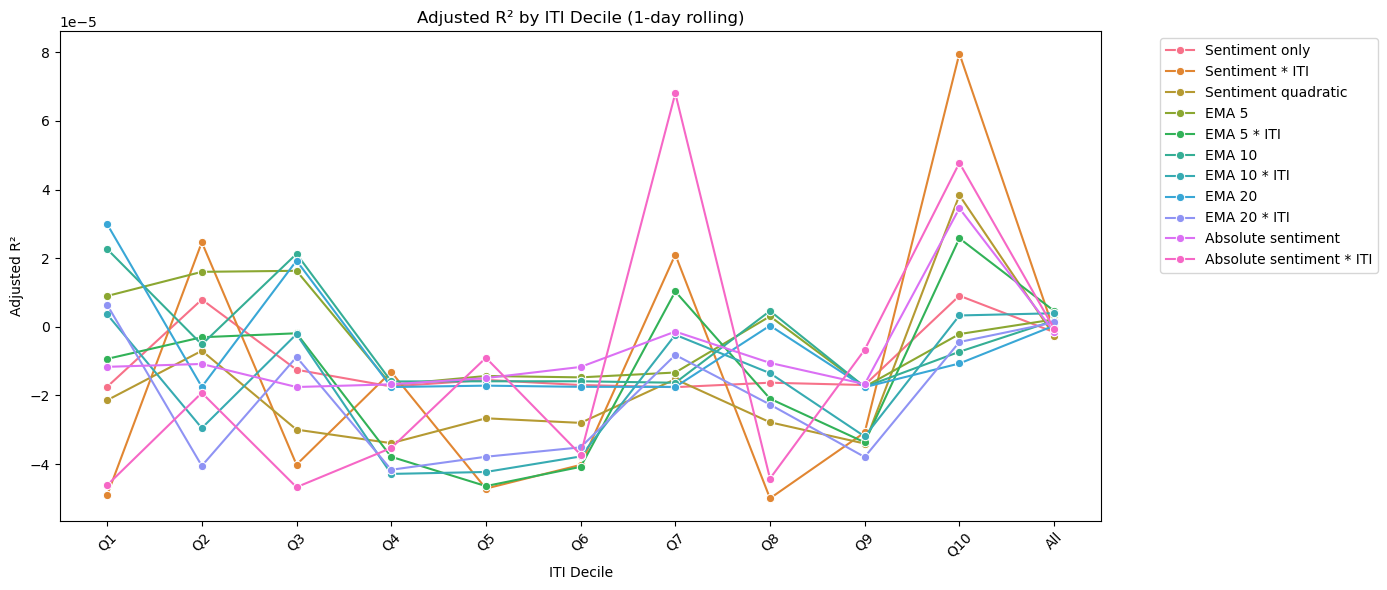

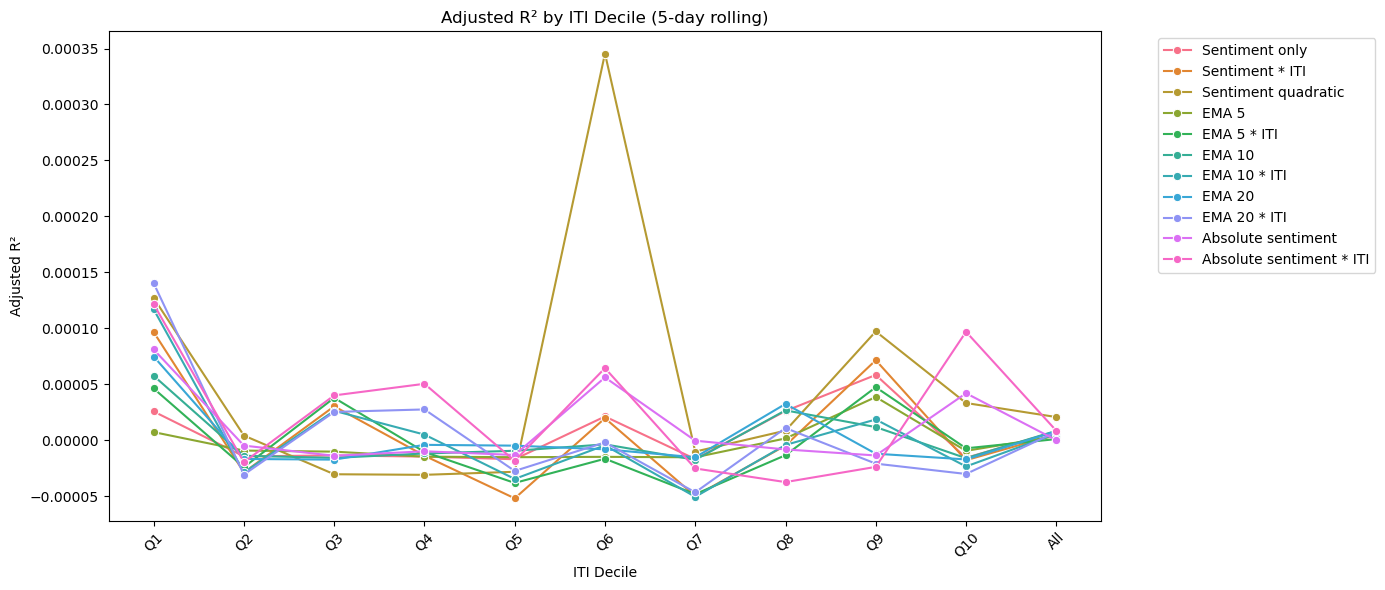

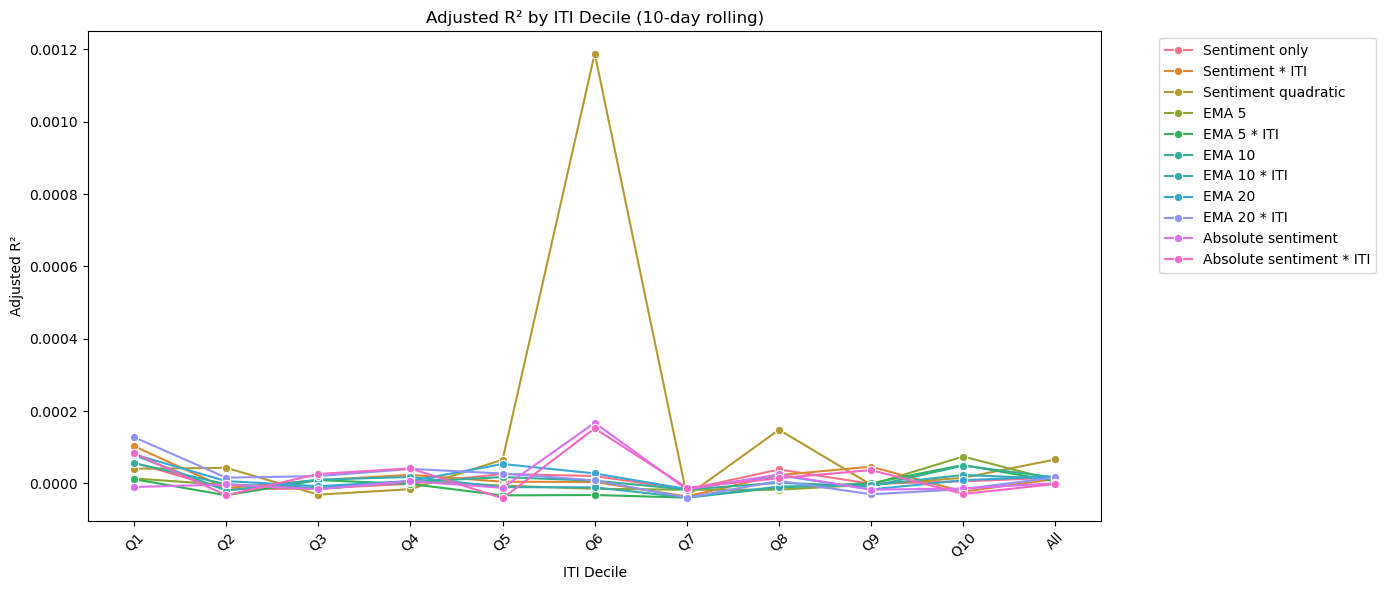

In [62]:
import polars as pl
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Rolling window sizes to consider ---
window_sizes = [1, 5, 10]  # in days

# --- Dictionary of regression tests ---
tests = {
    "Sentiment only": "next_day_ret ~ sentiment_mean",
    "Sentiment * ITI": "next_day_ret ~ sentiment_mean * ITI",
    "Sentiment quadratic": "next_day_ret ~ sentiment_mean + I(sentiment_mean**2)",
    "EMA 5": "next_day_ret ~ ema_sentiment_5_mean",
    "EMA 5 * ITI": "next_day_ret ~ ema_sentiment_5_mean * ITI",
    "EMA 10": "next_day_ret ~ ema_sentiment_10_mean",
    "EMA 10 * ITI": "next_day_ret ~ ema_sentiment_10_mean * ITI",
    "EMA 20": "next_day_ret ~ ema_sentiment_20_mean",
    "EMA 20 * ITI": "next_day_ret ~ ema_sentiment_20_mean * ITI",
    "Absolute sentiment": "next_day_ret ~ abs(sentiment_mean)",
    "Absolute sentiment * ITI": "next_day_ret ~ abs(sentiment_mean) * ITI",
}

# --- Function to compute rolling means for returns and sentiment ---
def add_rolling_means(df, window):
    # Sort by stock (permco) and date
    df = df.sort(["permco", "date"])
    # Compute rolling mean over the window for each stock
    df = df.with_columns([
        pl.col("next_day_ret").rolling_mean(window, min_samples=1).over("permco").alias(f"ret_mean_{window}"),
        pl.col("sentiment_mean").rolling_mean(window, min_samples=1).over("permco").alias(f"sent_mean_{window}")
    ])
    return df

# --- Function to run regressions and collect adjusted R² ---
def run_tests_collect(df, window_label):
    results = []
    df_pd = df.to_pandas()
    
    # --- Full dataset regressions ---
    for name, formula in tests.items():
        try:
            model = smf.ols(formula, data=df_pd).fit()
            results.append({"window": window_label, "decile": "All", "test": name, "adj_r2": model.rsquared_adj})
        except:
            results.append({"window": window_label, "decile": "All", "test": name, "adj_r2": None})
    
    # --- Decile-based regressions ---
    df_pd["ITI_decile"] = pd.qcut(df_pd["ITI"], 10, labels=[f"Q{i}" for i in range(1, 11)])
    for decile in df_pd["ITI_decile"].cat.categories:
        df_decile = df_pd[df_pd["ITI_decile"] == decile]
        for name, formula in tests.items():
            try:
                model = smf.ols(formula, data=df_decile).fit()
                results.append({"window": window_label, "decile": decile, "test": name, "adj_r2": model.rsquared_adj})
            except:
                results.append({"window": window_label, "decile": decile, "test": name, "adj_r2": None})
    return results

# --- Loop over rolling windows and collect results ---
all_results = []
for w in window_sizes:
    # Compute rolling averages
    df_window = add_rolling_means(df_daily, w)
    
    # Replace next_day_ret and sentiment_mean with rolling averages
    df_window_for_test = df_window.with_columns([
        pl.col(f"ret_mean_{w}").alias("next_day_ret"),
        pl.col(f"sent_mean_{w}").alias("sentiment_mean")
    ])
    
    # Run regressions and store results
    all_results.extend(run_tests_collect(df_window_for_test, f"{w}-day rolling"))

# --- Convert results to pandas DataFrame for plotting ---
df_results = pd.DataFrame(all_results)

# --- Ensure ITI decile ordering including "All" ---
decile_order = [f"Q{i}" for i in range(1, 11)] + ["All"]
df_results['decile'] = pd.Categorical(df_results['decile'], categories=decile_order, ordered=True)

# --- Loop to create a plot for each rolling window ---
for w in window_sizes:
    window_label = f"{w}-day rolling"
    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=df_results[df_results['window'] == window_label],
        x='decile', y='adj_r2', hue='test', marker="o"
    )
    plt.title(f"Adjusted R² by ITI Decile ({window_label})")
    plt.xlabel("ITI Decile")
    plt.ylabel("Adjusted R²")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()